In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn import model_selection
from sklearn import linear_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

matplotlib.style.use('fivethirtyeight')

In [2]:
trainDF = pd.read_csv('train.csv')
# trainDF = trainDF.dropna(how="any").reset_index(drop=True)

# trainDF.ix[:7,3:]

trainDF.ix[trainDF['question1'].isnull(),['question1','question2']] = 'random empty question'
trainDF.ix[trainDF['question2'].isnull(),['question1','question2']] = 'random empty question'


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [3]:
featureExtractionStartTime = time.time()

maxNumFeatures = 300000

# max_features = 300000
# min_df = 50
# ngram_range = (1,10)

# bag of letter sequences (chars)
BagOfWordsExtractor = CountVectorizer(max_df=0.999, min_df=50, max_features=maxNumFeatures, 
                                      analyzer='char', ngram_range=(1,10), 
                                      binary=True, lowercase=True)
# bag of words
#BagOfWordsExtractor = CountVectorizer(max_df=0.999, min_df=10, max_features=maxNumFeatures, 
#                                      analyzer='word', ngram_range=(1,6), stop_words='english', 
#                                      binary=True, lowercase=True)

BagOfWordsExtractor.fit(pd.concat((trainDF.ix[:,'question1'],trainDF.ix[:,'question2'])).unique())

trainQuestion1_BOW_rep = BagOfWordsExtractor.transform(trainDF.ix[:,'question1'])
trainQuestion2_BOW_rep = BagOfWordsExtractor.transform(trainDF.ix[:,'question2'])
lables = np.array(trainDF.ix[:,'is_duplicate'])

featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))

feature extraction took 16.70 minutes


In [4]:
# crossValidationStartTime = time.time()

# numCVSplits = 8
# numSplitsToBreakAfter = 2

X = (trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int)
#X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int) + \
#      trainQuestion1_BOW_rep.multiply(trainQuestion2_BOW_rep)
y = lables

In [5]:
X

<404290x300000 sparse matrix of type '<type 'numpy.int64'>'
	with 160875263 stored elements in Compressed Sparse Row format>

In [ ]:
testDF = pd.read_csv('test.csv')
testDF.ix[testDF['question1'].isnull(),['question1','question2']] = 'random empty question'
testDF.ix[testDF['question2'].isnull(),['question1','question2']] = 'random empty question'

testQuestion1_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question1'])
testQuestion2_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question2'])

X_test = (testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int)


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [52]:
X_test

<2345796x300000 sparse matrix of type '<type 'numpy.int64'>'
	with 1074994449 stored elements in Compressed Sparse Row format>

In [24]:
# trainingStartTime = time.time()

logisticRegressor = linear_model.LogisticRegression(C=1.0, solver='sag', max_iter = 400,
                                                    class_weight={1: 0.472001959, 0: 1.309028344})
# logisticRegressor.fit(X, y)
# 1.309028344, 1: 0.472001959
# trainingDurationInMinutes = (time.time()-trainingStartTime)/60.0
# print('full training took %.2f minutes' % (trainingDurationInMinutes))

In [16]:
from sklearn import model_selection
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

train_stacker=[ [0.0 for s in range(1)]  for k in range (0,(X.shape[0])) ]

cv_scores = []
oof_preds = []
a = [0 for x in range(2345796)]

# StratifiedKFold
# kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
# for dev_index, val_index in kf.split(range(x_train.shape[0]),y_train):
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(X.shape[0])):
        dev_X, val_X = X[dev_index,:], X[val_index,:]
        dev_y, val_y = y[dev_index], y[val_index]
        
        logisticRegressor.fit(dev_X, dev_y)
        predictions = logisticRegressor.predict_proba(val_X)

        cv_scores.append(log_loss(val_y, predictions))
#         cv_scores.append(log_loss(val_y, predictions*0.99))

        preds_tr = logisticRegressor.predict_proba(X_test)

        a = np.column_stack((a,preds_tr[:,1]))

        print(cv_scores)
#         break

        no=0
        for real_index in val_index:
            for d in range (0,1):
                train_stacker[real_index][d]=(predictions[no][1])
            no+=1


# [0.33876330067492622, 0.33499202082286755, 0.33509751915814967, 0.33530161167260025, 0.33567794961699643]
# [0.39461298473758771, 0.39299759059423106, 0.38932260764348808, 0.39055338835881326, 0.39384172959319402]


[0.43723966717300911]
[0.43723966717300911, 0.43651910944894778]
[0.43723966717300911, 0.43651910944894778, 0.43259718627466898]
[0.43723966717300911, 0.43651910944894778, 0.43259718627466898, 0.43514291461752358]
[0.43723966717300911, 0.43651910944894778, 0.43259718627466898, 0.43514291461752358, 0.4399267492490051]


In [50]:
b = pd.DataFrame(a)

b['sum'] = b.sum(axis = 1)/5

np.savetxt("train_stacker_sbxgb.gz", train_stacker, delimiter=",", fmt='%.6f')

print 'finished out of fold predictions on training set'             

np.savetxt("test_stacker_sbxgb.gz", np.array(b['sum']), delimiter=",", fmt='%.6f')


# np.savetxt("sbench_train_oof.csv", train_stacker, delimiter=",", fmt='%.6f')

# # tpred = pd.read_csv("shallowBenchmark.csv")

# np.savetxt("sbench_test.csv", tpred.iloc[:,1], delimiter=",", fmt='%.6f')


finished out of fold predictions on training set


In [18]:
x_tr = np.loadtxt("lstm_feat_train1.gz",  delimiter="," )

x_ts = np.loadtxt("lstm_feat_test1.gz",  delimiter=",")


In [25]:
from sklearn import model_selection
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

train_stacker=[ [0.0 for s in range(1)]  for k in range (0,(x_tr.shape[0])) ]

cv_scores = []
oof_preds = []
a = [0 for x in range(2345796)]

# StratifiedKFold
# kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
# for dev_index, val_index in kf.split(range(x_train.shape[0]),y_train):
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(x_tr.shape[0])):
        dev_X, val_X = x_tr[dev_index,:], x_tr[val_index,:]
        dev_y, val_y = y[dev_index], y[val_index]
        
        logisticRegressor.fit(dev_X, dev_y)
        predictions = logisticRegressor.predict_proba(val_X)

        cv_scores.append(log_loss(val_y, predictions))
#         cv_scores.append(log_loss(val_y, predictions*0.99))

        preds_tr = logisticRegressor.predict_proba(x_ts)

        a = np.column_stack((a,preds_tr[:,1]))

        print(cv_scores)
#         break

        no=0
        for real_index in val_index:
            for d in range (0,1):
                train_stacker[real_index][d]=(predictions[no][1])
            no+=1



[0.7469701460136714]
[0.7469701460136714, 0.74884881146308946]
[0.7469701460136714, 0.74884881146308946, 0.74416138131410026]
[0.7469701460136714, 0.74884881146308946, 0.74416138131410026, 0.74408915593525482]
[0.7469701460136714, 0.74884881146308946, 0.74416138131410026, 0.74408915593525482, 0.74458521316234505]


In [10]:
RS = 2016
ROUNDS = 400

print("Started")
np.random.seed(RS)
input_folder = ''

import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.5
params['max_depth'] = 15
params['seed'] = RS
params['gamma'] = 2
params['subsample'] = 0.75
params['colsample_bytree'] = 0.75
params['min_child_weight'] = 10
params['reg_alpha'] = 2
# params['reg_lambda'] = 2
params['n_jobs'] = 20

from sklearn import model_selection
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

y_train = np.array(y)

train_stacker=[ [0.0 for s in range(1)]  for k in range (0,(X.shape[0])) ]

cv_scores = []
oof_preds = []
a = [0 for x in range(2345796)]
# StratifiedKFold
# kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
# for dev_index, val_index in kf.split(range(x_train.shape[0]),y_train):
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(X.shape[0])):
        dev_X, val_X = X[dev_index,:], X[val_index,:]
        dev_y, val_y = y_train[dev_index], y_train[val_index]
        print dev_X.shape
        print val_X.shape

        d_train = xgb.DMatrix(dev_X, label=dev_y)
        d_valid = xgb.DMatrix(val_X, label=val_y)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]

        bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=25, verbose_eval=100)
        # ntree_limit=model.best_ntree_limit
        m = 0.1742 / 0.369 
        n = (1 - 0.1742) / (1 - 0.369)
        
        pds = bst.predict(d_valid, ntree_limit=bst.best_ntree_limit)

        preds = m * pds / (m * pds + n * (1 - pds))
        cv_scores.append(log_loss(val_y, preds))

        print(cv_scores)
#         break
        
        d_test = xgb.DMatrix(X_test)
        ptr = bst.predict(d_test, ntree_limit=bst.best_ntree_limit)
        

        preds_tr = m * ptr / (m * ptr + n * (1 - ptr))

        a = np.column_stack((a,preds_tr))

        no=0
        for real_index in val_index:
            for d in range (0,1):
                train_stacker[real_index][d]=(preds[no])
            no+=1
        break    
# 

Started
(323432, 300000)
(80858, 300000)
[0]	train-logloss:0.604153	valid-logloss:0.609411
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 25 rounds.
[100]	train-logloss:0.326518	valid-logloss:0.392395
[200]	train-logloss:0.283737	valid-logloss:0.374297
[300]	train-logloss:0.255041	valid-logloss:0.368074
[400]	train-logloss:0.233451	valid-logloss:0.364698
[500]	train-logloss:0.215599	valid-logloss:0.362425
[600]	train-logloss:0.200949	valid-logloss:0.361226
Stopping. Best iteration:
[593]	train-logloss:0.202	valid-logloss:0.361141

[0.41645345742109469]


MemoryError: 

In [9]:
preds_tr

array([ 0.00635584,  0.58894253,  0.24508519, ...,  0.00603709,
        0.10678211,  0.23628864], dtype=float32)

In [53]:
import lightgbm as lgbm
# 'metric': 'binary_logloss', 'num_boost_round' :1000,
t4_params = {
    'boosting_type': 'gbdt', 'objective': 'binary', 'nthread': 12, 'silent': True,
    'num_leaves': 2**6, 'learning_rate': 0.1, 'max_depth': 12,
    'max_bin': 255, 'subsample_for_bin': 50000,
    'subsample': 0.75, 'subsample_freq': 1, 'colsample_bytree': 0.75, 'reg_alpha':2, 'reg_lambda':0,
    'min_split_gain': 0.5, 'min_child_weight': 10, 'min_child_samples': 2, 'scale_pos_weight': 1}

from sklearn import model_selection
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

In [57]:
y_train = np.array(y)

train_stacker=[ [0.0 for s in range(1)]  for k in range (0,(X.shape[0])) ]

cv_scores = []
oof_preds = []
a = [0 for x in range(2345796)]
# StratifiedKFold
# kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
# for dev_index, val_index in kf.split(range(x_train.shape[0]),y_train):
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(X.shape[0])):
        dev_X, val_X = X[dev_index,:], X[val_index,:]
        dev_y, val_y = y_train[dev_index], y_train[val_index]
        print dev_X.shape
        print val_X.shape
        
        t4 = lgbm.sklearn.LGBMClassifier(n_estimators=2000, seed=2016, **t4_params)
        bst = t4.fit(dev_X, dev_y, 
                       eval_set = [(val_X,val_y)], eval_metric = 'logloss',early_stopping_rounds = 20, verbose =25) 

        m = 0.1742 / 0.369 
        n = (1 - 0.1742) / (1 - 0.369)
        
        pds = bst.predict_proba(val_X)
        
        preds = m * pds / (m * pds + n * (1 - pds))

        cv_scores.append(log_loss(val_y, preds))

        ptr = bst.predict_proba(X_test)
        preds_tr = m * ptr / (m * ptr + n * (1 - ptr))

        a = np.column_stack((a,preds_tr[:,1]))
        print(cv_scores)

        no=0
        for real_index in val_index:
            for d in range (0,1):
                train_stacker[real_index][d]=(preds[no][1])
            no+=1

(323432, 300000)
(80858, 300000)


TypeError: Expected np.float32 or np.float64, met type(int64)

In [5]:
testPredictionStartTime = time.time()

%matplotlib inline

testDF = pd.read_csv('test.csv')
testDF.ix[testDF['question1'].isnull(),['question1','question2']] = 'random empty question'
testDF.ix[testDF['question2'].isnull(),['question1','question2']] = 'random empty question'

testQuestion1_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question1'])
testQuestion2_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question2'])

X_test = (testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int)


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


predicting on test took 45.95 minutes


/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


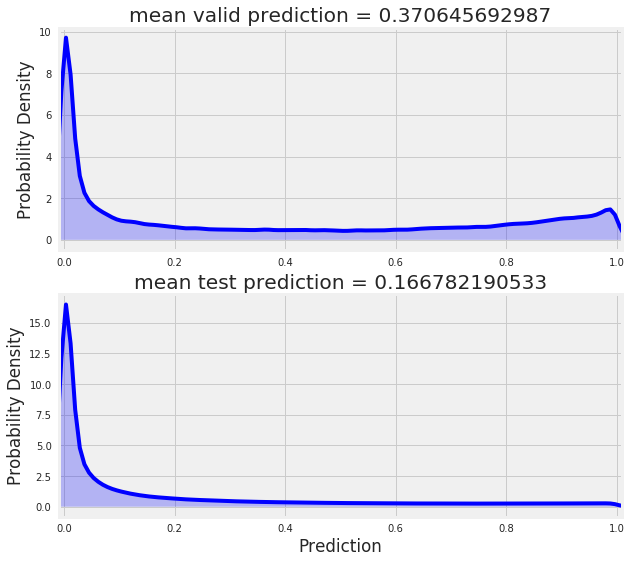

In [32]:
testPredictionStartTime = time.time()

%matplotlib inline

testDF = pd.read_csv('test.csv')
testDF.ix[testDF['question1'].isnull(),['question1','question2']] = 'random empty question'
testDF.ix[testDF['question2'].isnull(),['question1','question2']] = 'random empty question'

testQuestion1_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question1'])
testQuestion2_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question2'])

X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int)
#X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int) + \
#           testQuestion1_BOW_rep.multiply(testQuestion2_BOW_rep)

#testPredictions = logisticRegressor.predict_proba(X_test)[:,1]

# quick fix to avoid memory errors
seperators= [750000,1500000]
testPredictions1 = logisticRegressor.predict_proba(X_test[:seperators[0],:])[:,1]
testPredictions2 = logisticRegressor.predict_proba(X_test[seperators[0]:seperators[1],:])[:,1]
testPredictions3 = logisticRegressor.predict_proba(X_test[seperators[1]:,:])[:,1]
testPredictions = np.hstack((testPredictions1,testPredictions2,testPredictions3))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9,9)

plt.figure(); 
plt.subplot(2,1,1); sns.kdeplot(y_valid_hat, shade=True, color="b", bw=0.01); 
plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean valid prediction = ' + str(np.mean(y_valid_hat)))
plt.subplot(2,1,2); sns.kdeplot(testPredictions, shade=True, color="b", bw=0.01);
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean test prediction = ' + str(np.mean(testPredictions)))

testPredictionDurationInMinutes = (time.time()-testPredictionStartTime)/60.0
print('predicting on test took %.2f minutes' % (testPredictionDurationInMinutes))

In [35]:
# pd.DataFrame(testPredictions).head()

np.savetxt("sbench_test.csv", testPredictions, delimiter=",", fmt='%.6f')

In [18]:
# tr_tsne

# np.savetxt("sbenchfeat_tsvd100_train.gz", tr_tsne, delimiter=",", fmt='%.6f')
# test_tsne = dim.fit_transform(X_test)
np.savetxt("sbenchfeat_tsvd100_test.gz", test_tsne, delimiter=",", fmt='%.6f')


In [15]:
from sklearn.manifold import TSNE,MDS,Isomap
from sklearn.decomposition import TruncatedSVD,NMF,LatentDirichletAllocation,FastICA

# dim = TSNE(n_components= 10, perplexity=30.0, early_exaggeration=4.0, learning_rate=1000.0, n_iter=1000, 
#                       n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0, 
#                       random_state=None,  angle=0.5)
# dim = MDS(n_components=10, metric=True, n_init=4, max_iter=300, verbose=1, eps=0.001, n_jobs=1, random_state=None, 
#           dissimilarity='euclidean')

dim = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=5, random_state=2016, tol=0.0)

# dim = FastICA(n_components=None, algorithm='parallel', whiten=True, fun='logcosh', fun_args=None, max_iter=200, tol=0.0001, 
#               w_init=None, random_state=None)
# dim = Isomap(n_neighbors=5, n_components=100, eigen_solver='auto', tol=0, max_iter=None, 
#        path_method='auto', neighbors_algorithm='auto', n_jobs=-1)
tr_tsne = dim.fit_transform(X)

# test_tsne = dim.fit_transform(x_test)

In [17]:
test_tsne = dim.transform(X_test)

# print(dim.explained_variance_ratio_.sum())

In [14]:
print tr_tsne.shape


AttributeError: 'TruncatedSVD' object has no attribute 'shape'

In [14]:
#%% create a submission

submissionName = 'shallowBenchmark'

submission = pd.DataFrame()
submission['test_id'] = testDF['test_id']
submission['is_duplicate'] = testPredictions
submission.to_csv(submissionName + '.csv', index=False)